In [1]:
!pip install qiskit

In [33]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import assemble
from qiskit.tools import job_monitor
from qiskit import transpile, schedule as build_schedule
from qiskit.pulse import Schedule, Play, Gaussian, DriveChannel,ShiftPhase, Drag
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import plot_histogram

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [34]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-11-17 23:11:03,875: Credentials are already in use. The existing account in the session will be replaced.


In [35]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [36]:
dt = backend_config.dt

print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [37]:
backend_defaults = backend.defaults()

In [38]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

scale_factor=1e-14
# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")



Qubit 0 has an estimated frequency of 4.97443934149293 GHz.


In [39]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [40]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play,Drag
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.035                   # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*4        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt - Multiply Scaling factor
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt - Multiply Scaling factor
drive_amp = 0.6 # - Divide Scaling factor
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In [41]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [42]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [43]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [44]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 1
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [45]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

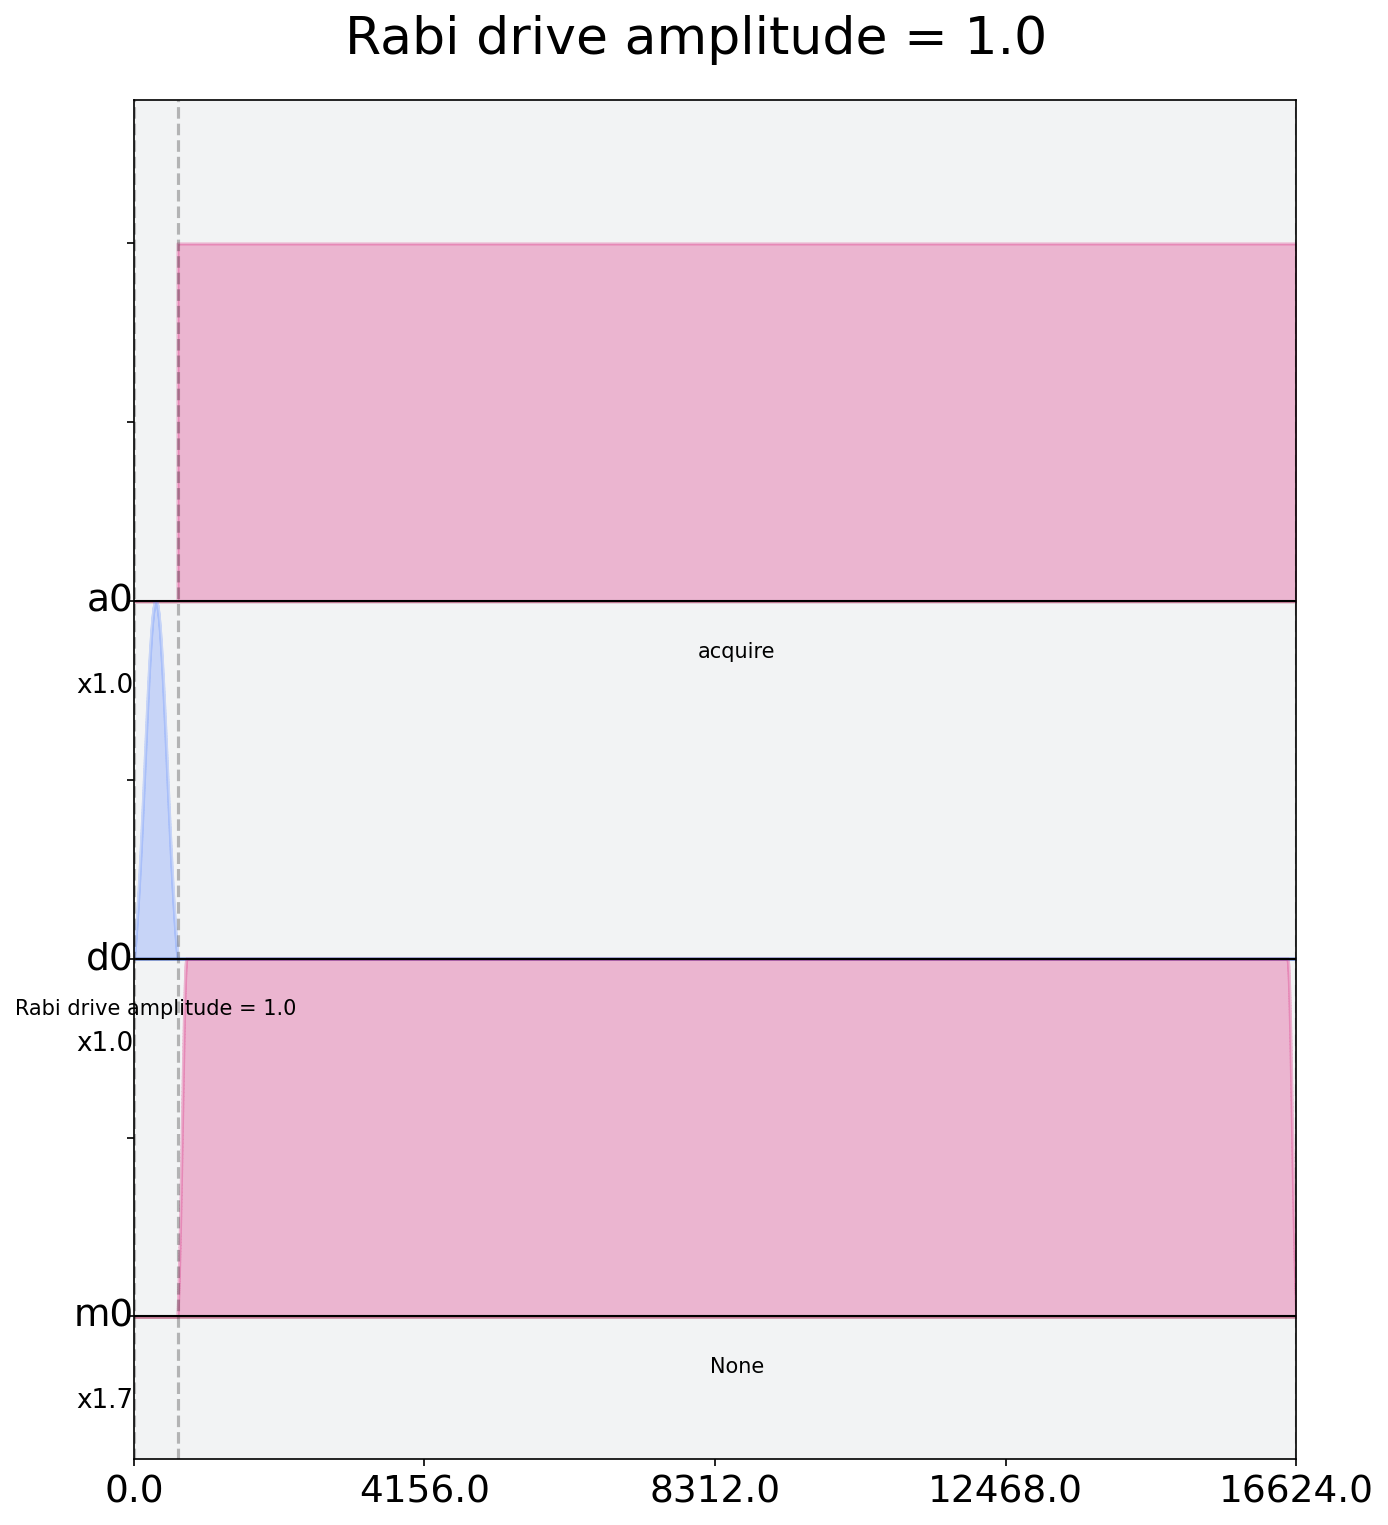

In [46]:
rabi_schedules[-1].draw(label=True)

In [47]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: backend_defaults.qubit_freq_est[0]}]
                                                * num_rabi_points)

In [19]:
# print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

Job Status: job is queued (10)    

KeyboardInterrupt: ignored

In [ ]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

In [ ]:
rabi_results = job.result(timeout=120)

In [85]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

print(rabi_values)
plt.scatter(np.real(baseline_remove(rabi_values)), np.imag(baseline_remove(rabi_values)), color='black') # plot real part of Rabi values
plt.show()


NameError: ignored

In [ ]:
rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

In [32]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [ ]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0, 1,0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [ ]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

In [ ]:
# Create two schedules

# Ground state schedule
gnd_schedule = pulse.Schedule(name="ground state")
gnd_schedule += measure

# Excited state schedule
exc_schedule = pulse.Schedule(name="excited state")
exc_schedule += Play(Gaussian(duration=drive_samples, amp=pi_amp+0j, sigma=drive_sigma), drive_chan)
exc_schedule += measure << exc_schedule.duration

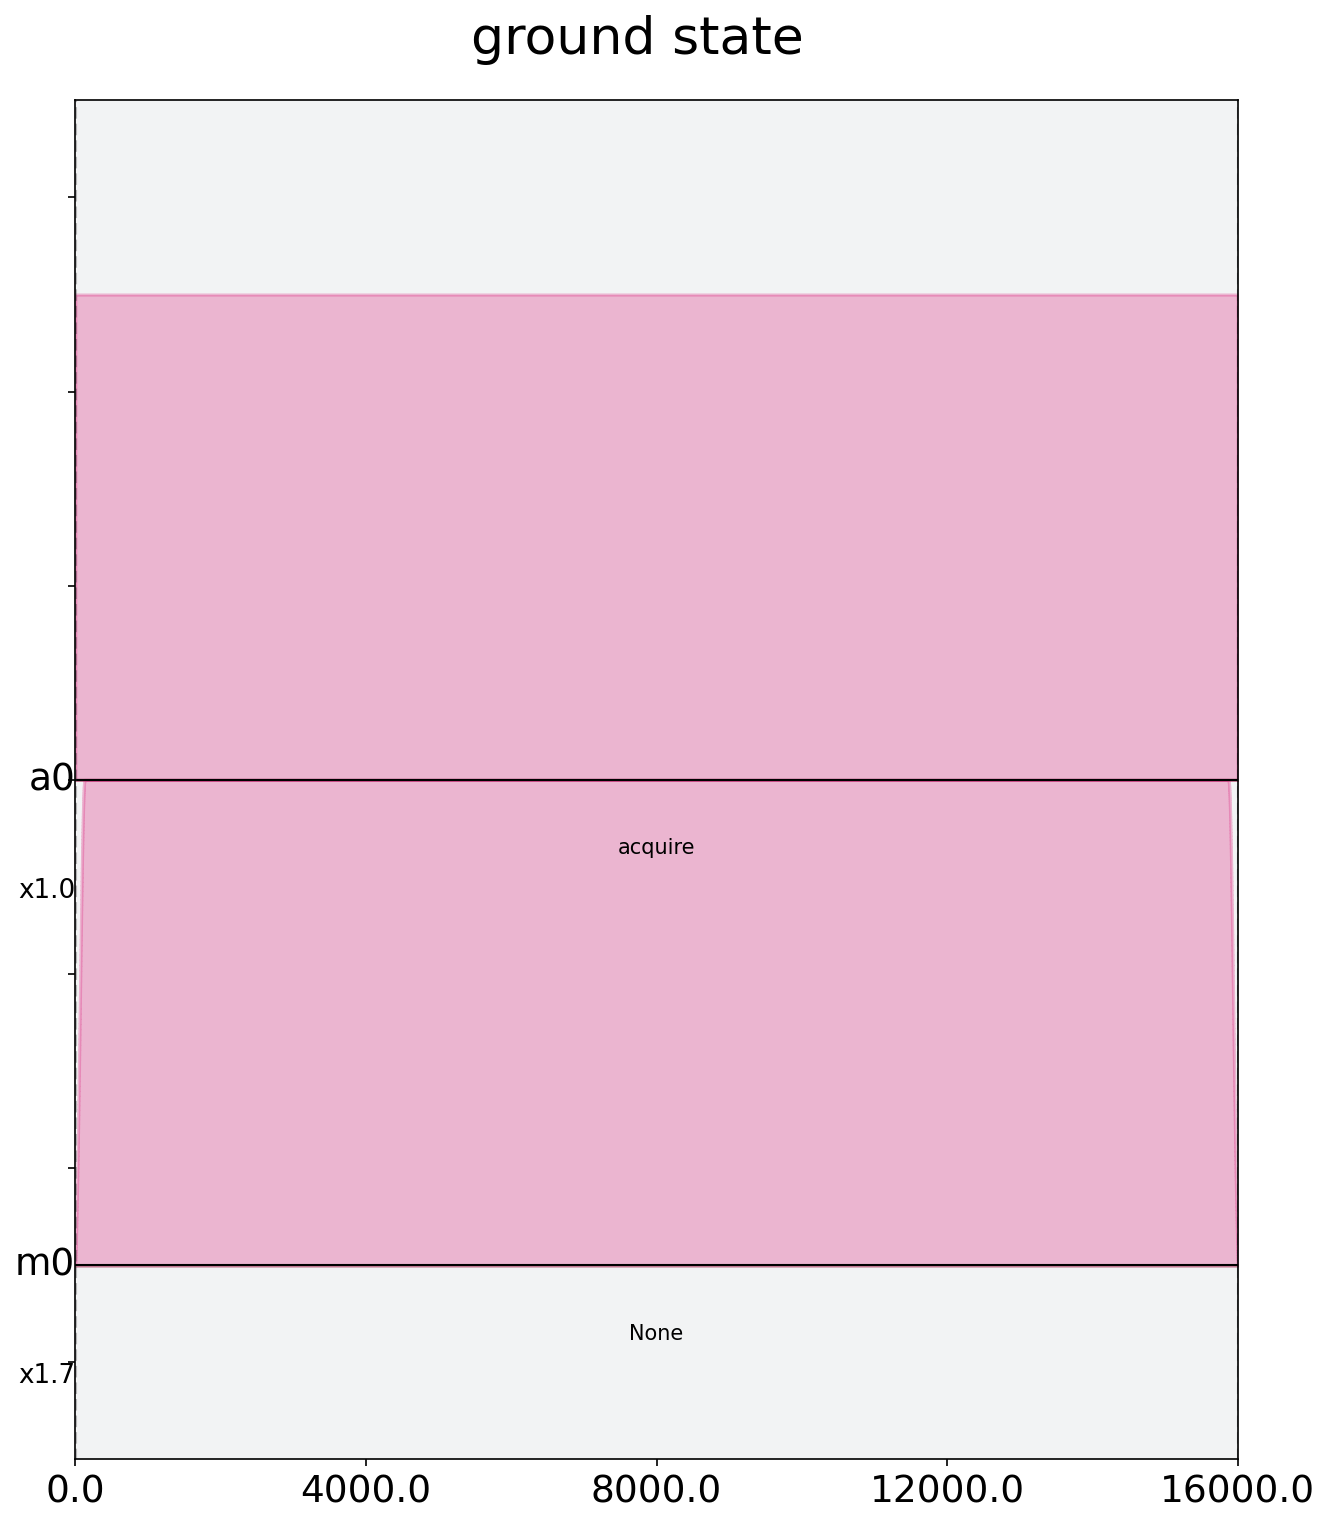

In [ ]:
gnd_schedule.draw(label=True)

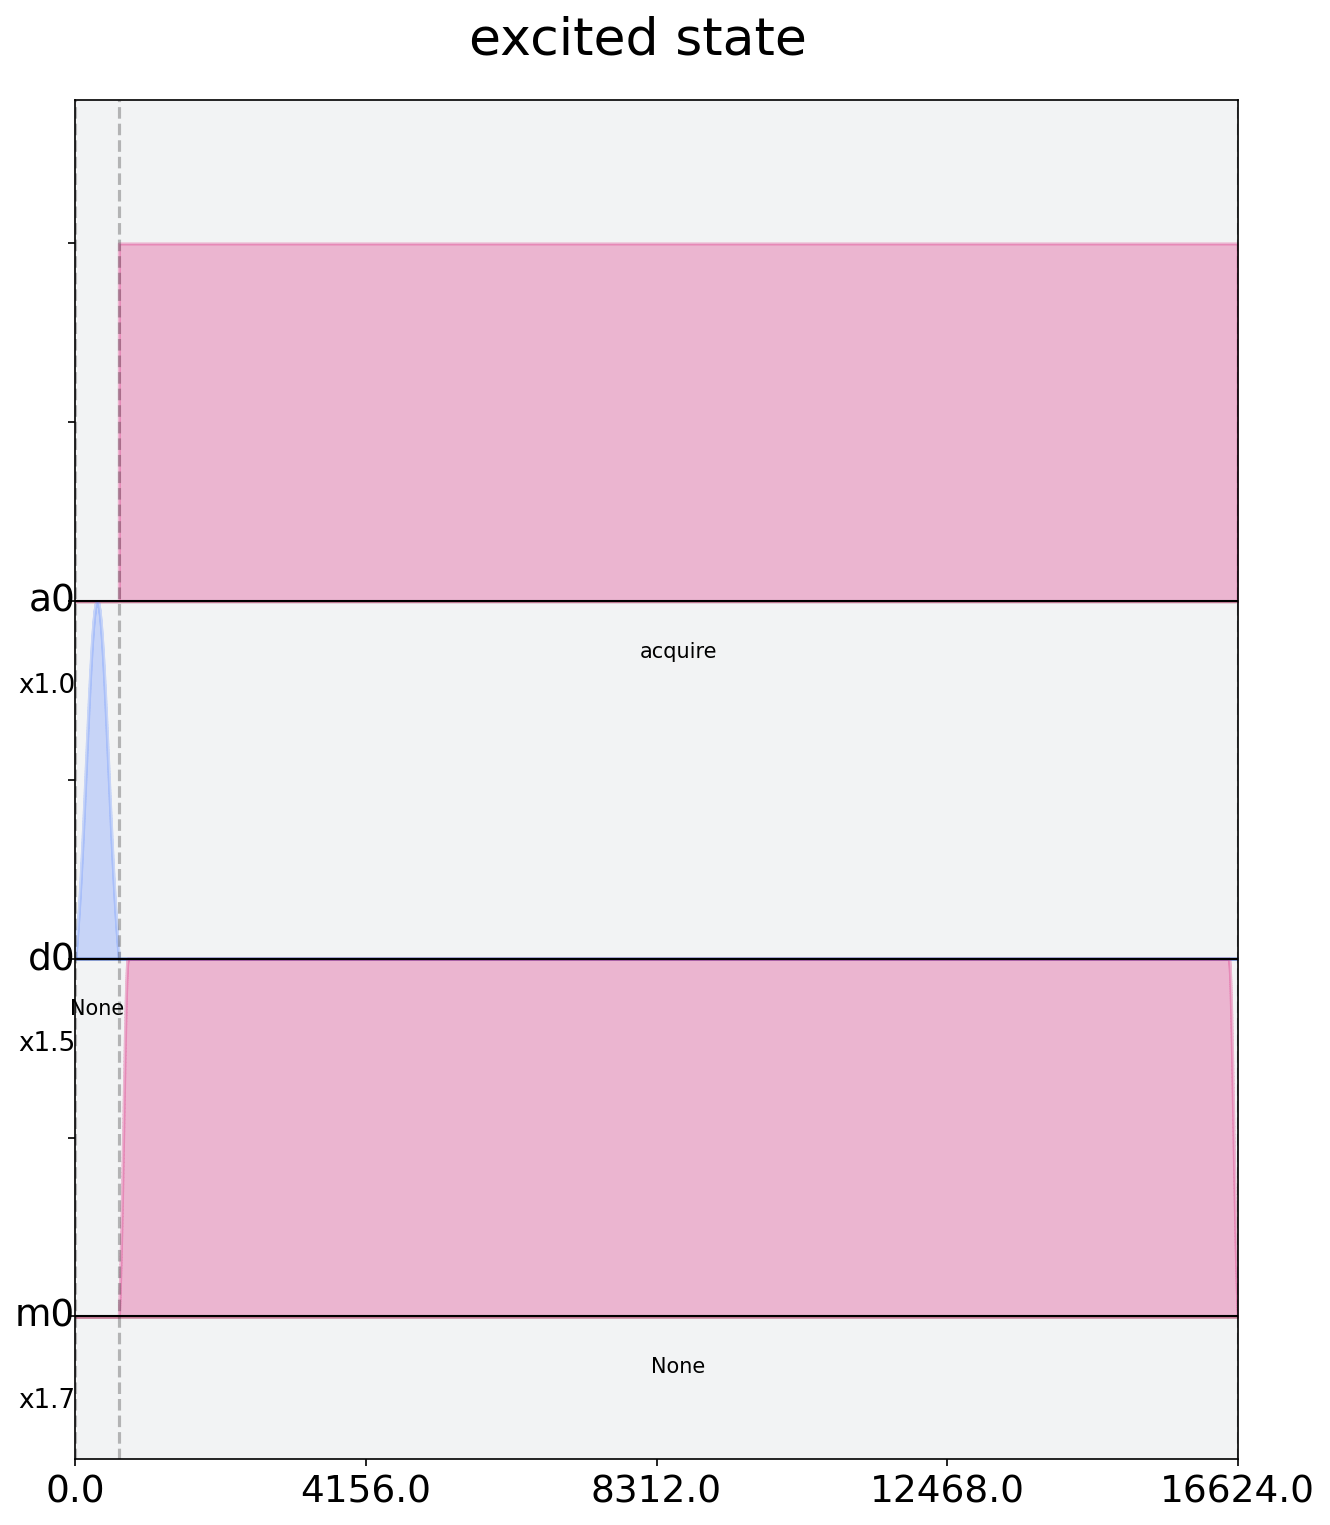

In [ ]:
exc_schedule.draw(label=True)

In [ ]:
num_shots = 512

gnd_exc_program = assemble([gnd_schedule,exc_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots)

In [ ]:
# print(job.job_id())
job = backend.run(gnd_exc_program)
job_monitor(job)

Job Status: job has successfully run


In [ ]:
 gnd_exc_results = job.result(timeout=120)

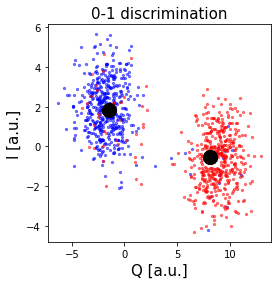

In [ ]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

In [ ]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))

In [ ]:
print(mean_exc)
print(mean_gnd)

(8.14263447934976-0.53709190935232j)
(-1.48149998014976+1.83067501150208j)


In [ ]:
def get_U2_sched(phi,lam,name):
  sched_circuit = pulse.Schedule(name=name)
  sched_circuit |= ShiftPhase(-lam, drive_chan) 
  sched_circuit |=  Play(Drag(duration=drive_samples, amp=pi_amp/2, sigma=drive_sigma, beta=-3.503413439291586),drive_chan)
  sched_circuit += ShiftPhase(-phi, drive_chan)  
  sched_circuit += measure << sched_circuit.duration
  return sched_circuit

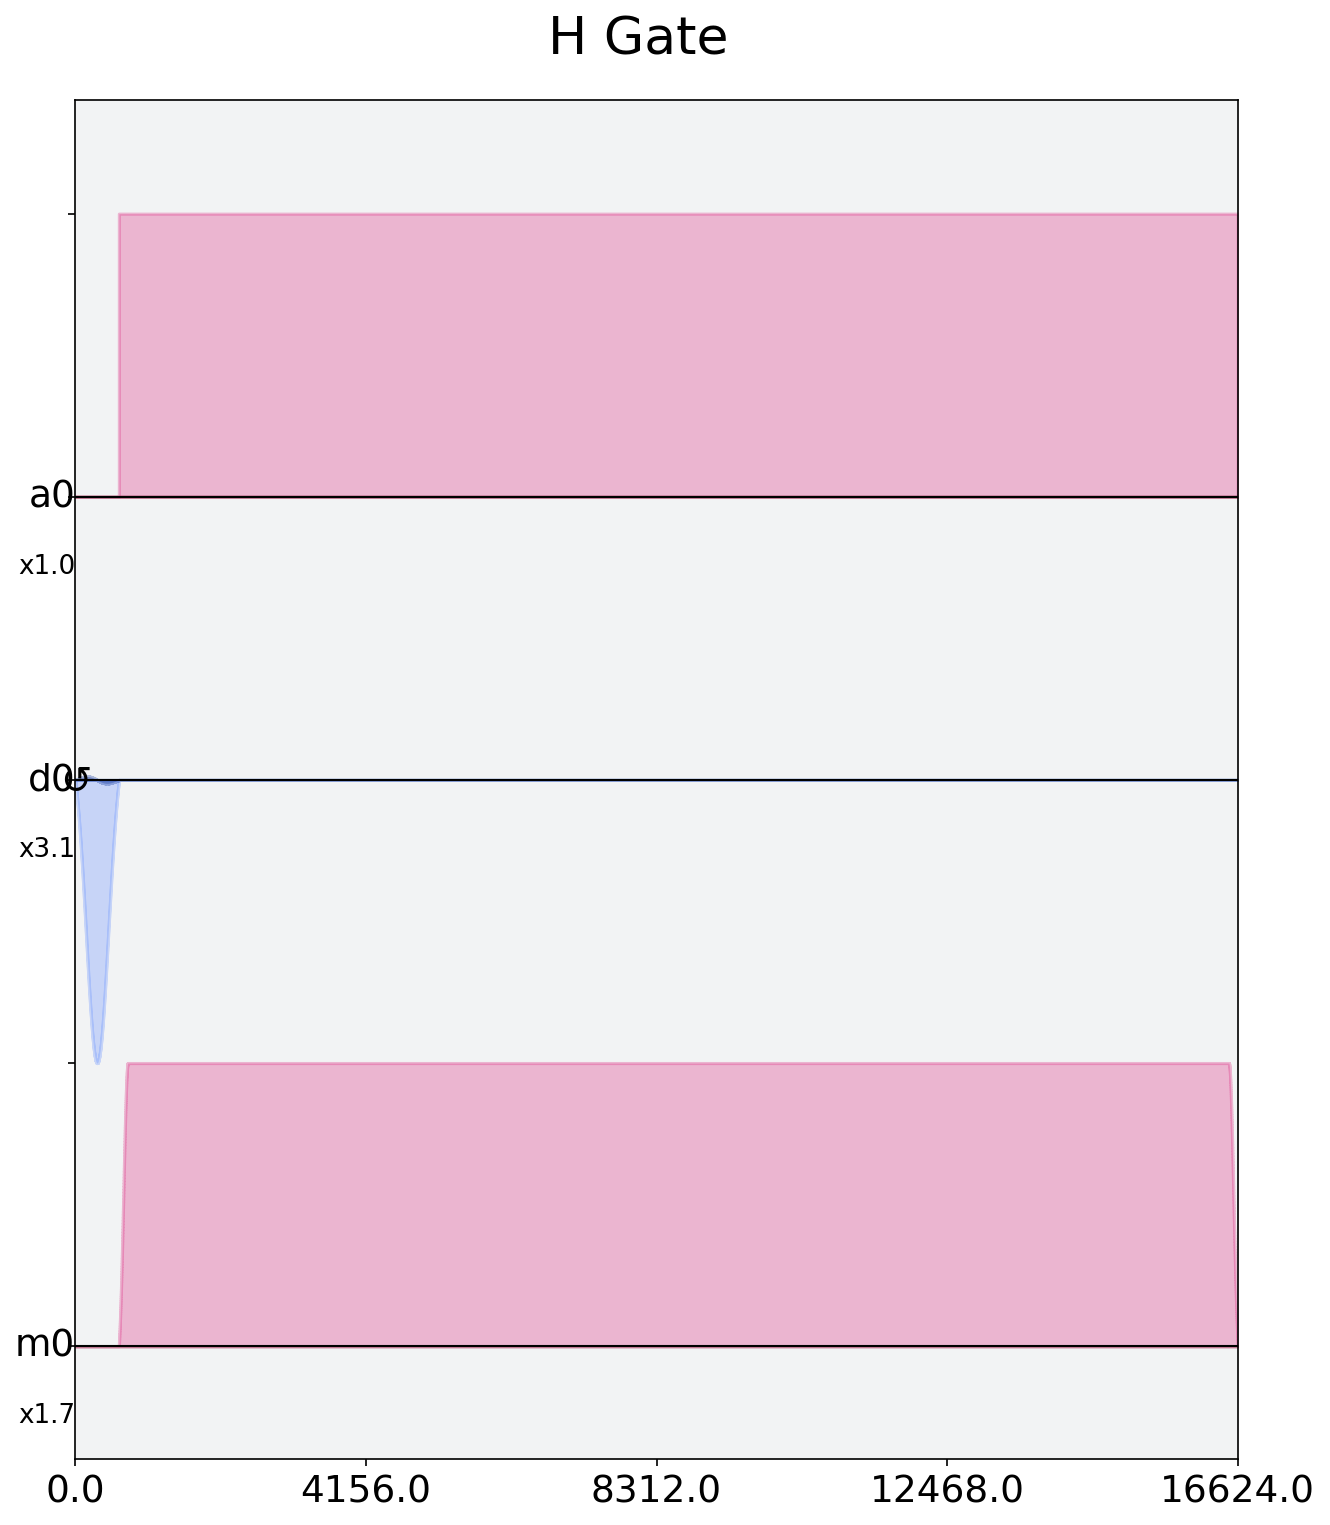

In [ ]:
sched_circuit = get_U2_sched(0,np.pi,"H Gate")
sched_circuit.draw()

In [ ]:
num_shots = 1024

h_exc_program = assemble([gnd_schedule,sched_circuit],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots)

In [ ]:
# print(job.job_id())
job = backend.run(h_exc_program)
job_monitor(job)

Job Status: job has successfully run


In [ ]:
h_exc_results = job.result(timeout=120)

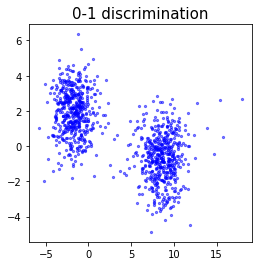

In [ ]:
h_results = h_exc_results.get_memory(1)[:, qubit]*scale_factor
#exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(h_results), np.imag(h_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.title("0-1 discrimination", fontsize=15)

plt.show()

In [ ]:
res = [x for x in [classify(complex(n.real,n.imag)) for n in h_results]]

In [ ]:
print(f'0 count : {res.count(0)}')
print(f'1 count : {res.count(1)}')

0 count : 508
1 count : 516


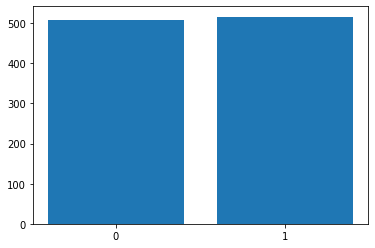

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.bar([0,1],[res.count(0),res.count(1)])
plt.xticks([0,1])
plt.show()

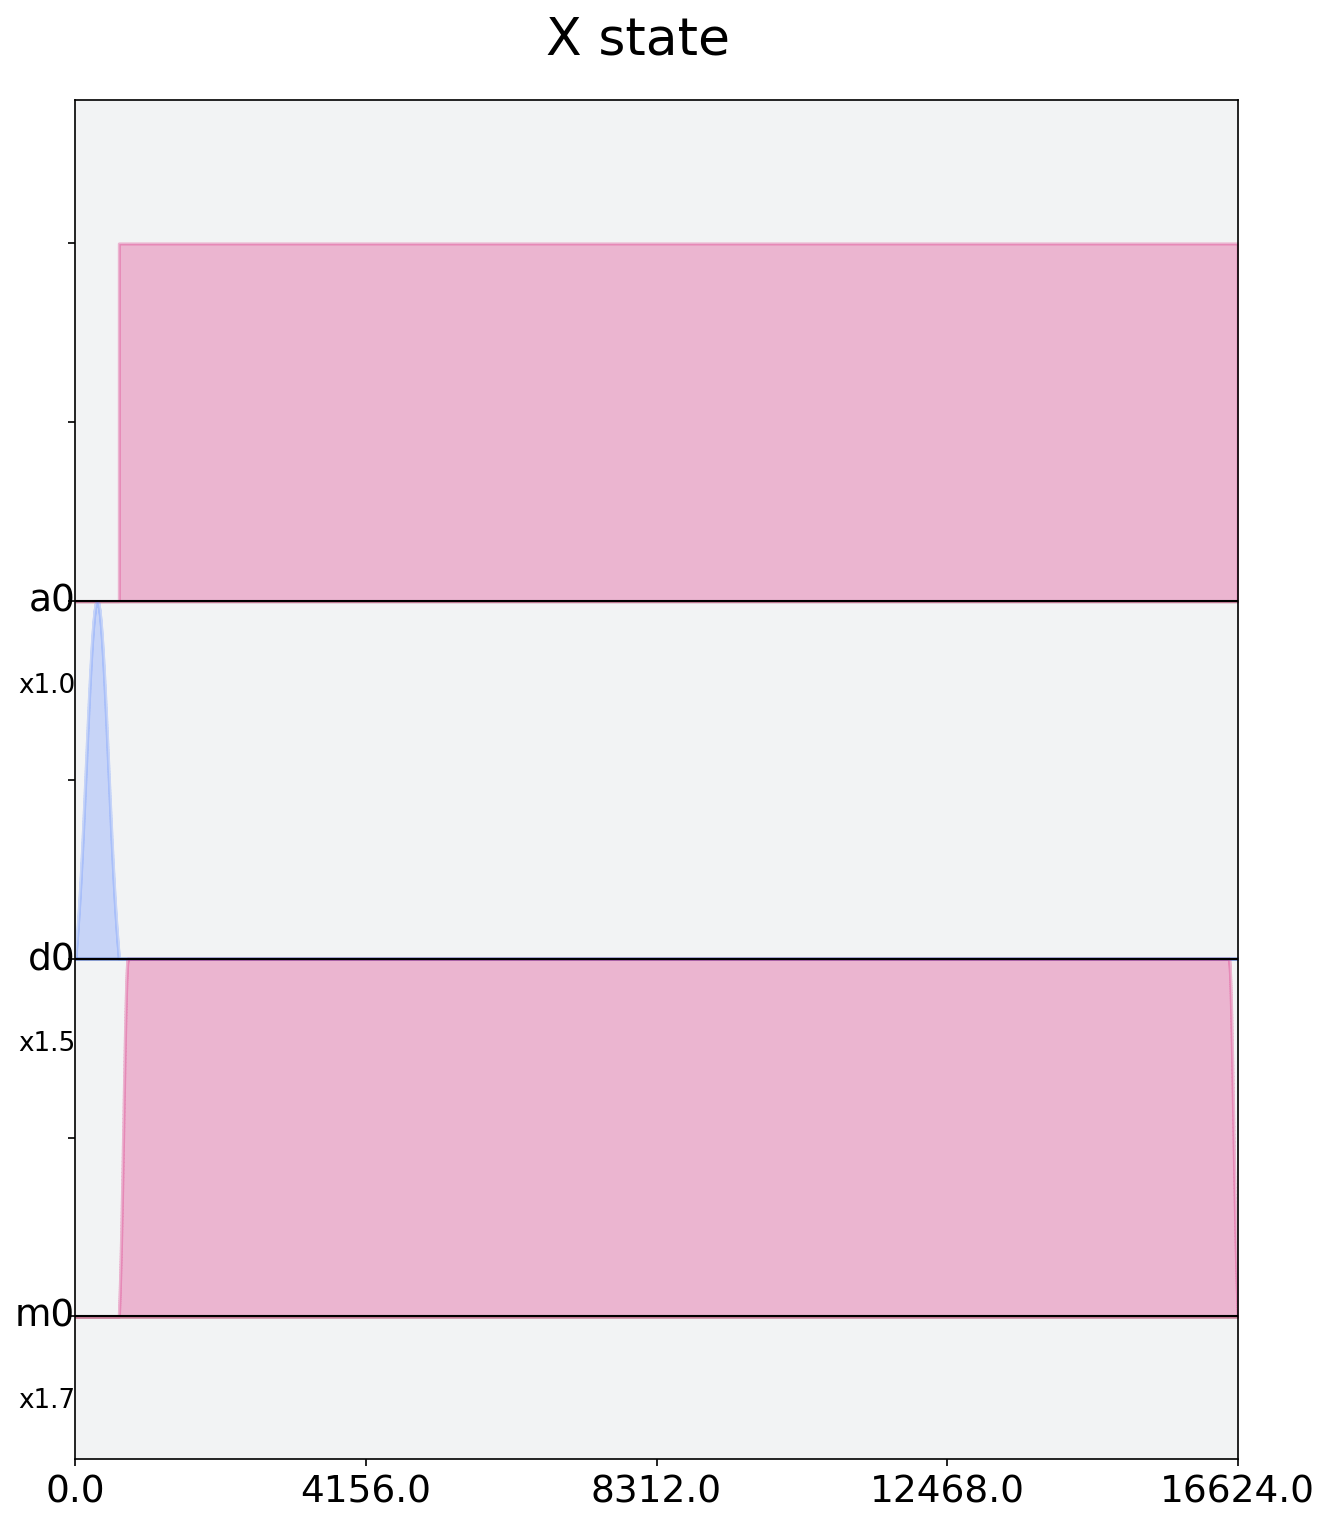

In [ ]:
sched_circuit = pulse.Schedule(name="X state")
sched_circuit |=  Play(Gaussian(duration=drive_samples, amp=pi_amp, sigma=160),drive_chan)
sched_circuit += measure << sched_circuit.duration
sched_circuit.draw()

In [ ]:
num_shots = 1024

x_exc_program = assemble([gnd_schedule,sched_circuit],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots)

In [ ]:
# print(job.job_id())
job = backend.run(h_exc_program)
job_monitor(job)

Job Status: job has successfully run


In [ ]:
x_exc_results = job.result(timeout=120)

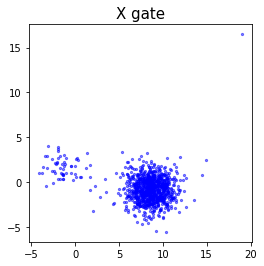

In [ ]:
x_results = x_exc_results.get_memory(1)[:, qubit]*scale_factor


plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(x_results), np.imag(x_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.title("X gate", fontsize=15)

plt.show()

The above plot shows the measured signal values on running the X-Gate.
X-Axis denotes the real component(Q) and Y-axis denotes the imaginary(I) component of the result.

In [ ]:
res = [x for x in [classify(complex(n.real,n.imag)) for n in x_results]]

In [ ]:
print(f'0 count : {res.count(0)}')
print(f'1 count : {res.count(1)}')

0 count : 37
1 count : 987


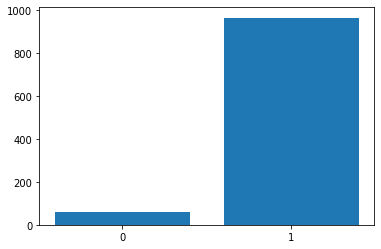

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.bar([0,1],[res.count(0),res.count(1)])
plt.xticks([0,1])
plt.show()

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import BasicAer, execute
from qiskit.tools.visualization import plot_histogram

In [ ]:
# Build the phase shift circuit
qc = QuantumCircuit(1,1)
qc.x(0)
qc.measure(0,0)
qc.draw()


┌───┐┌─┐
q_0: ┤ X ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

In [ ]:
iterations = 20
results_Default = []
for i in range(iterations):

  job = execute(qc, backend, shots=1024)
  job_monitor(job)   # shots default = 1024
  result = job.result()
  results_Default.append(result.get_counts())

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [ ]:

print(sum(d['0'] for d in results_Default) / len(results_Default))
print(sum(d['1'] for d in results_Default) / len(results_Default))

77.4
946.6


Average Results over Default Circuit excecution (20 iterations)

In [ ]:
# print(job.job_id())
iterations = 20
results = []
for i in range(iterations):
  job = backend.run(x_exc_program)
  job_monitor(job)  # shots default = 1024
  result = job.result()
  x_results = result.get_memory(1)[:, qubit]*scale_factor
  res = [x for x in [classify(complex(n.real,n.imag)) for n in x_results]]
  results.append({'0':res.count(0),'1':res.count(1)})

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [ ]:
print(f'Avg 0 count : {sum(d["0"] for d in results) / len(results)}')
print(f'Avg 1 count : {sum(d["1"] for d in results) / len(results)}')

Avg 0 count : 60.75
Avg 1 count : 963.25


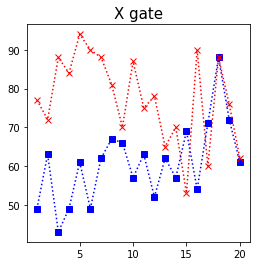

In [ ]:
plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.plot(range(1,21),[x["0"] for x in results],':' ,
               c='blue', marker="s")
plt.plot(range(1,21),[x["0"] for x in results_Default],':',c='red', marker = "x")
# All results from the exc_schedule are plotted in red
plt.title("X gate", fontsize=15)

plt.show()

In [ ]:
def get_U3_sched(theta,phi,lam,name):
  sched_circuit = pulse.Schedule(name=name)
  sched_circuit |= ShiftPhase(-lam, drive_chan) 
  sched_circuit |= Play(Drag(duration=drive_samples, amp=pi_amp/2, sigma=drive_sigma, beta=-3.503413439291586),drive_chan)
  sched_circuit += ShiftPhase(-theta, drive_chan)  
  sched_circuit += Play(Drag(duration=drive_samples, amp=-pi_amp/2, sigma=drive_sigma, beta=-3.503413439291586),drive_chan)
  sched_circuit += ShiftPhase(-phi, drive_chan) 
  sched_circuit += measure << sched_circuit.duration
  return sched_circuit

def get_U1_sched(lam,name):
  sched_circuit = pulse.Schedule(name=name)
  sched_circuit |= ShiftPhase(-lam, drive_chan) 
  sched_circuit += measure << sched_circuit.duration
  return sched_circuit

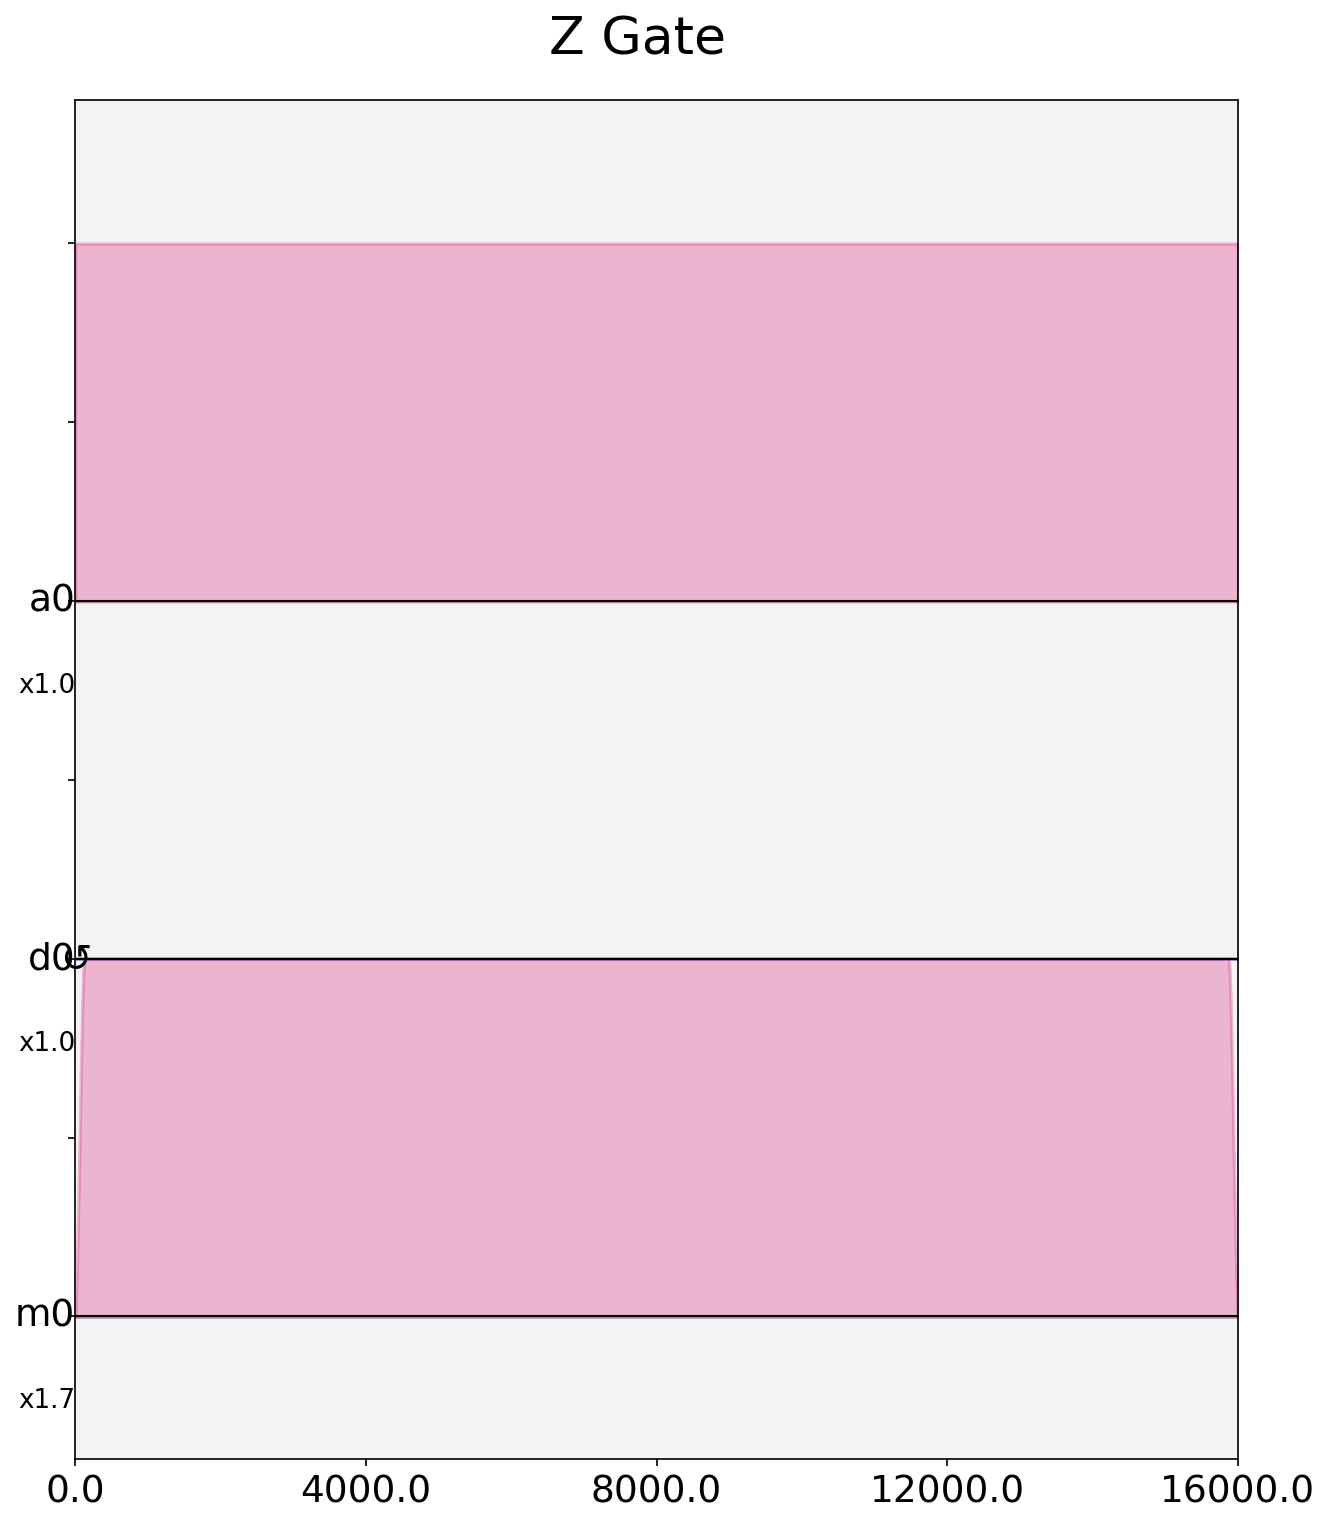

In [ ]:
pi_amp=0.5977610131 #Test value
x_gate = get_U1_sched(np.pi,"Z Gate")
x_gate.draw()

##Compare the generated/calibrated Pulse schedules against the Default Gate Pulse schedules.

In [82]:
qc = QuantumCircuit(1,1)
qc.u3(np.pi,-np.pi/2,np.pi/2,0)
qc.measure(0,0)
qc.draw()

┌────────────────┐┌─┐
q_0: ┤ U3(π,-π/2,π/2) ├┤M├
     └────────────────┘└╥┘
c: 1/═══════════════════╩═
                        0

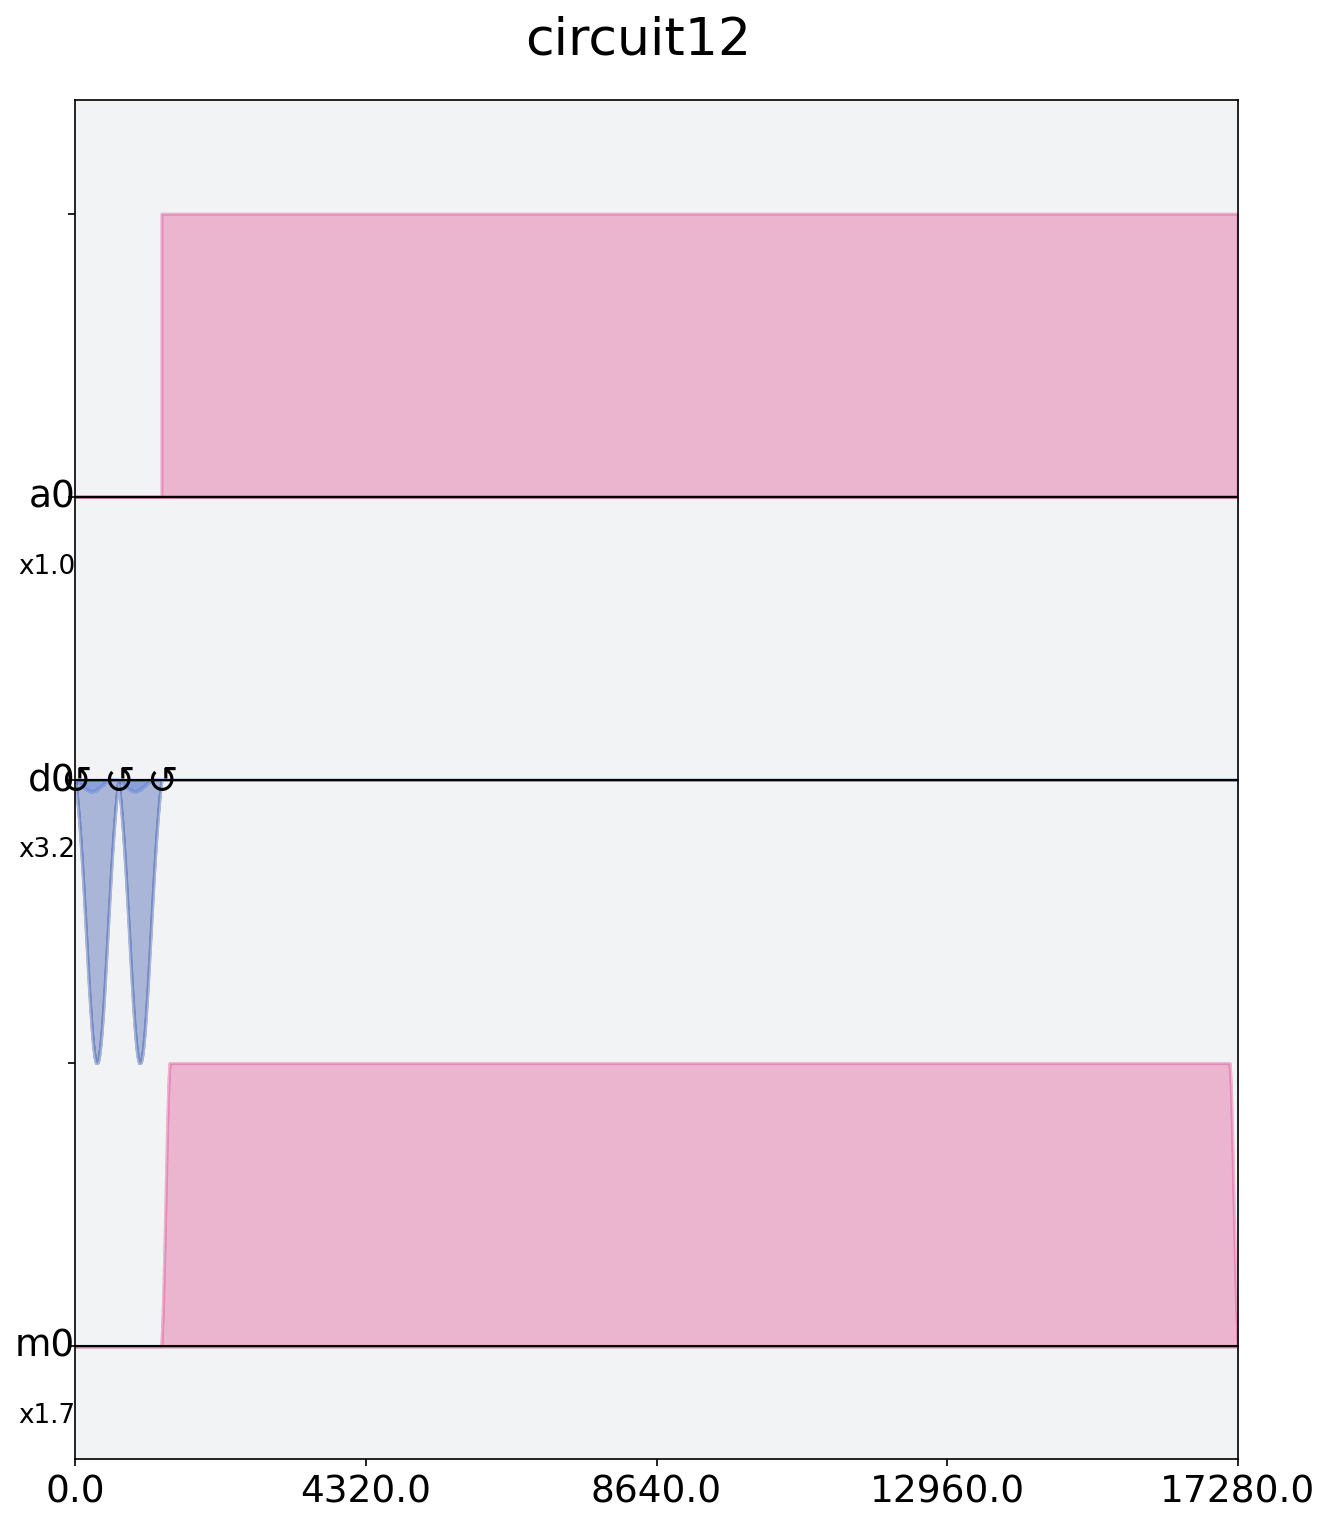

In [81]:
sched = build_schedule(qc,backend)
sched.draw()

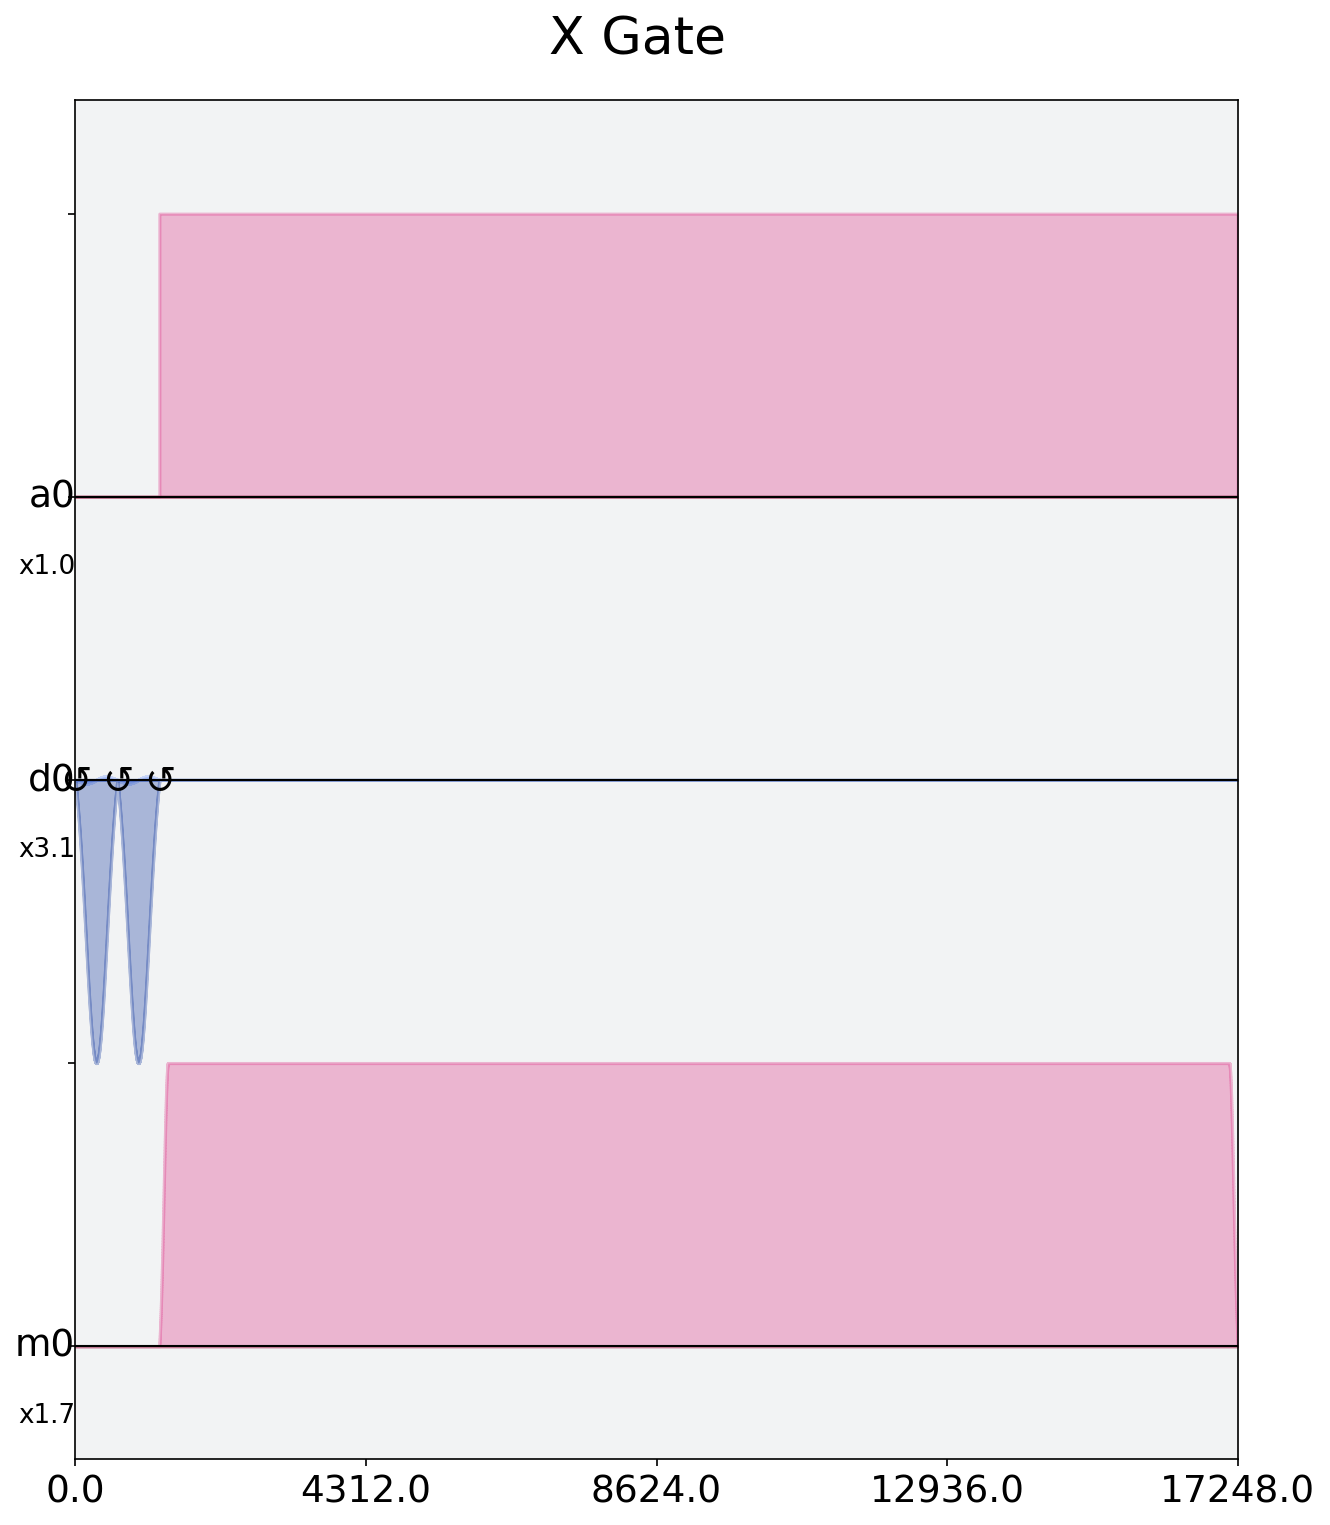

In [84]:
pi_amp=0.6471987717
x_gate = get_U3_sched(np.pi,-np.pi/2,np.pi/2,"X Gate")
x_gate.draw()